In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import pcntoolkit as ptk 
from pcntoolkit.dataio.fileio import load as ptkload
from pcntoolkit.dataio.fileio import save as ptksave
from pcntoolkit.normative import predict, evaluate
from pcntoolkit.util.utils import compute_MSLL, create_design_matrix, calibration_descriptives

from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pingouin as pg

from scipy import stats
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal

import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

from pathlib  import Path
#!pip install ptitprince
import ptitprince as pt



# globals
root_dir = '/project_cephfs/3022017.06/ENIGMA_ANX/'
proc_dir = os.path.join(root_dir,'Z_stat/')
data_dir = os.path.join(proc_dir,'data/')
vox_dir = os.path.join(proc_dir,'vox/')
w_dir = os.path.join(proc_dir,'vox/')
mask_nii = ('/opt/fmriprep/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-02_desc-brain_mask.nii.gz')
ex_nii = os.path.join(data_dir, 'ENIGMA_FC_tr_1.nii.gz')

/home/preclineu/hansav/.conda/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/preclineu/hansav/.conda/envs/py38/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home/preclineu/hansav/.conda/envs/py38/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home/preclineu/hansav/.conda/envs/py38/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and wil

In [2]:
#Load in Z_data
Z_est_clinical = ptkload(os.path.join(vox_dir,'Z_predcl.pkl'), mask=mask_nii)

In [3]:
#Load in the diagnosis information
metadata_cl_diagnosis = pd.read_csv('/project_cephfs/3022017.06/ENIGMA_ANX/Z_stat/data/clinical_te.csv')
Diagnoses_info = pd.read_csv('/project_cephfs/3022017.06/ENIGMA_ANX/Z_stat/data/all_test_validation.csv', usecols = ['SubjectID_ENIGMA', 'Principal_diagnosis_current'] )
merged_clinical_test_data = pd.merge(metadata_cl_diagnosis, Diagnoses_info, on='SubjectID_ENIGMA', how='left')
merged_clinical_test_data['Principal_diagnosis_current'] = merged_clinical_test_data['Principal_diagnosis_current'].replace({np.nan: 'NA', 'nan': 'NA'})

In [4]:
#split the Z_est clinical into the control and patients  ***and remove other and schizophrenia as diagnosis are not of interest***
mask_Diganosis = merged_clinical_test_data['Healthy_or_patient'].eq(1)
mask_exclude_diagnosis = ~merged_clinical_test_data['Principal_diagnosis_current'].isin(['others', 'schizophrenia'])
 #remove other and schizophrenia as not primary affective conditions 
combined_Diagnosis_mask = mask_Diganosis & mask_exclude_diagnosis

print(len(mask_Diganosis))
print(len(mask_exclude_diagnosis))
print(len(combined_Diagnosis_mask))


Diagnoses_info = merged_clinical_test_data[combined_Diagnosis_mask]
Affective_sample_deviations = Z_est_clinical[combined_Diagnosis_mask]

581
581
581


In [5]:
print(len(Affective_sample_deviations))
print(len(Diagnoses_info))
Primary_Diagnoses = np.unique(merged_clinical_test_data['Principal_diagnosis_current'])
Primary_Diagnoses = [diagnosis for diagnosis in Primary_Diagnoses if diagnosis not in ['NA', 'others', 'schizophrenia']]
print('Diagnoses that will be analysed: ', Primary_Diagnoses)

222
222
Diagnoses that will be analysed:  ['gad', 'major depressive disorder', 'ocd', 'panic disorder', 'ptsd', 'sad', 'specific phobia']


In [6]:
#Count large deviations per participant, per diagnosis
max_length = 100  # Initialize max_length to track the maximum length of any column
counts_df = pd.DataFrame(index=range(max_length))

for d in Primary_Diagnoses:
    mask_Diganosis = Diagnoses_info['Principal_diagnosis_current'].eq(d)
    print(sum(mask_Diganosis == True), d)
    Z_est_Diagnosis = Affective_sample_deviations[mask_Diganosis]

    counts = []
    for z in range(len(Z_est_Diagnosis)):
        count_value = sum((Z_est_Diagnosis[z] < -2.6) | (Z_est_Diagnosis[z] > 2.6))
        counts.append(count_value)
    # Update max_length if the current column is longer
    current_length = len(counts)
    max_length = max(max_length, current_length)
    
    # Pad the counts with NaN values if the length is less than max_length
    counts_df[d] = counts + [np.nan] * (max_length - current_length)

# Save DataFrame to CSV file
counts_df.to_csv('counts_per_diagnosis.csv', index=False)

# Save DataFrame to CSV file
counts_df.to_csv('/project_cephfs/3022017.06/ENIGMA_ANX/Z_stat/vox/NPM_comparisons/counts_per_diagnosis_affective_only.csv', index=False)
   

48 gad
11 major depressive disorder
68 ocd
2 panic disorder
55 ptsd
31 sad
7 specific phobia


In [7]:
#H-TEST and follow up FDR corrected Mann Whittney U tests
counts_df = pd.read_csv('/project_cephfs/3022017.06/ENIGMA_ANX/Z_stat/vox/NPM_comparisons/counts_per_diagnosis_affective_only.csv')
print(counts_df)
# Creating the DataFrame
counts = pd.DataFrame(counts_df)

# Reshape the DataFrame to long format
long_format = counts.melt(var_name='Principal_diagnosis_current', value_name='value').dropna()

# Prepare the groups for the Kruskal-Wallis test
groups = [long_format[long_format['Principal_diagnosis_current'] == diagnosis]['value'].values 
          for diagnosis in long_format['Principal_diagnosis_current'].unique()]

# Perform the Kruskal-Wallis H test
statistic, p_value = kruskal(*groups)
# Display the results
print(f"Kruskal-Wallis H test statistic: {statistic}")
print(f"P-value: {p_value}")


      gad  major depressive disorder      ocd  panic disorder    ptsd     sad  \
0   750.0                      941.0  16216.0          2622.0   178.0  8166.0   
1   746.0                      773.0    720.0          3451.0   272.0   288.0   
2   640.0                      184.0    158.0             NaN    53.0   388.0   
3   263.0                      245.0    630.0             NaN  1241.0   625.0   
4   168.0                      230.0  13253.0             NaN   912.0  8275.0   
..    ...                        ...      ...             ...     ...     ...   
95    NaN                        NaN      NaN             NaN     NaN     NaN   
96    NaN                        NaN      NaN             NaN     NaN     NaN   
97    NaN                        NaN      NaN             NaN     NaN     NaN   
98    NaN                        NaN      NaN             NaN     NaN     NaN   
99    NaN                        NaN      NaN             NaN     NaN     NaN   

    specific phobia  
0    

There is a significant difference between at least two groups.
gad vs major depressive disorder: U-test value = 393.0, Uncorrected P-value = 0.0123855627655235, Corrected P-value = 0.021674734839666126
gad vs ocd: U-test value = 1035.5, Uncorrected P-value = 0.0008348900722981999, Corrected P-value = 0.0019480768353624665
gad vs panic disorder: U-test value = 3.0, Uncorrected P-value = 0.02758550412523968, Corrected P-value = 0.04137825618785952
gad vs ptsd: U-test value = 424.0, Uncorrected P-value = 3.2145476597226845e-09, Corrected P-value = 6.750550085417638e-08
gad vs sad: U-test value = 1004.5, Uncorrected P-value = 0.009041140134558695, Corrected P-value = 0.017260358438702963
gad vs specific phobia: U-test value = 39.0, Uncorrected P-value = 0.001173790483004354, Corrected P-value = 0.0024649600143091437
major depressive disorder vs ocd: U-test value = 127.0, Uncorrected P-value = 0.0004817297632619876, Corrected P-value = 0.0012645406285627175
major depressive disorder vs pani

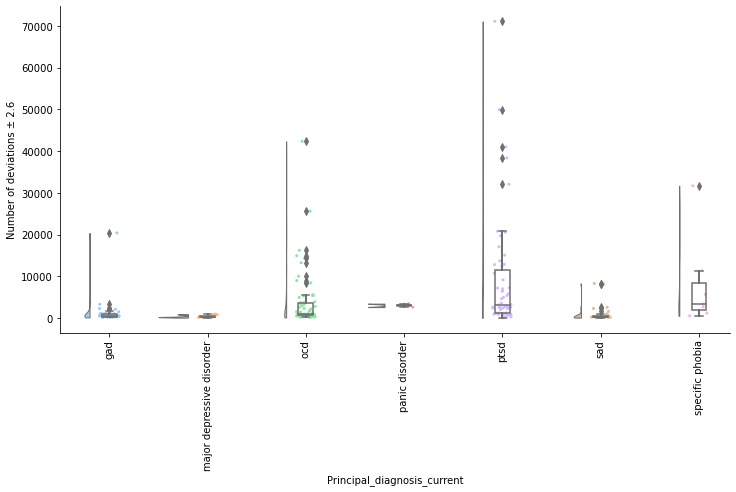

In [8]:
# Check for significance
if p_value < 0.05:
    print("There is a significant difference between at least two groups.")
    
    pairwise_results = []
    diagnoses = long_format['Principal_diagnosis_current'].unique()
    
    for i in range(len(groups)):
        for j in range(i + 1, len(groups)):
            group1 = groups[i]
            group2 = groups[j]
    
            # Perform Mann-Whitney U test with alternative='two-sided' to get U-statistic
            u_statistic, mw_p_value = mannwhitneyu(group1, group2, alternative='two-sided')
            pairwise_results.append((f"{diagnoses[i]} vs {diagnoses[j]}", mw_p_value, u_statistic))
    
    # Correct for multiple comparisons
    corrected_p_values = multipletests([p for _, p, _ in pairwise_results], method='fdr_bh')[1]
    
    # Display results for significant comparisons
    for (comparison, original_p_value, u_statistic), corrected_p_value in zip(pairwise_results, corrected_p_values):
        if corrected_p_value < 0.05:
            print(f"{comparison}: U-test value = {u_statistic}, Uncorrected P-value = {original_p_value}, Corrected P-value = {corrected_p_value}")

    # Visualize group differences using raincloud plots
    plt.figure(figsize=(12, 6))
    ax = pt.RainCloud(data=long_format, x='Principal_diagnosis_current', y='value', 
                      palette='pastel', bw=0.2, width_viol=0.6, ax=None, orient='v')
    sns.despine(top=True, right=True, left=False, bottom=False)
    plt.xlabel('Principal_diagnosis_current')
    plt.ylabel('Number of deviations ± 2.6')
    plt.xticks(rotation=90)
    plt.show()

else:
    print("No significant difference detected between groups.")

In [9]:
#SUMMARY TABLE OF MEDIAN COUNTS AND STD
counts_df_ref = pd.read_csv('/project_cephfs/3022017.06/ENIGMA_ANX/Z_stat/vox/NPM_comparisons/counts_hist_affective_only.csv')

# Columns to include from counts_df_ref
columns_to_include = ['reference_counts', 'control_counts', 'clinical_counts']

# Create a DataFrame to store median and std for each column
summary_table = pd.DataFrame(columns=['Column', 'Median', 'Std'])

# Calculate median and std for each column in counts_df_cleaned
#for col in columns_to_include:
#    mean_value = np.mean(counts_df[col].dropna())
#    median_value = np.median(counts_df[col].dropna())
#    std_value = np.std(counts_df[col].dropna())
#    summary_table = pd.concat([summary_table, pd.DataFrame({'Column': [col], 'Mean': [mean_value], 'Median': [median_value], 'Std': [std_value]})], ignore_index=True)#

# Calculate median and std for each column in counts_df_ref
for col in columns_to_include:
    mean_value = np.mean(counts_df_ref[col].dropna())
    median_value = np.median(counts_df_ref[col].dropna())
    std_value = np.std(counts_df_ref[col].dropna())
    summary_table = pd.concat([summary_table, pd.DataFrame({'Column': [col], 'Mean': [mean_value], 'Median': [median_value], 'Std': [std_value]})], ignore_index=True)

# Display the summary table
print(summary_table)

             Column  Median          Std         Mean
0  reference_counts  1261.0  5728.821726  3207.238390
1    control_counts   967.0  7276.467692  3365.776923
2   clinical_counts   861.5  8710.794106  4047.896396


ValueError: `stat` must be one of ['count', 'density', 'probability', 'frequency'], but percent was passed.`

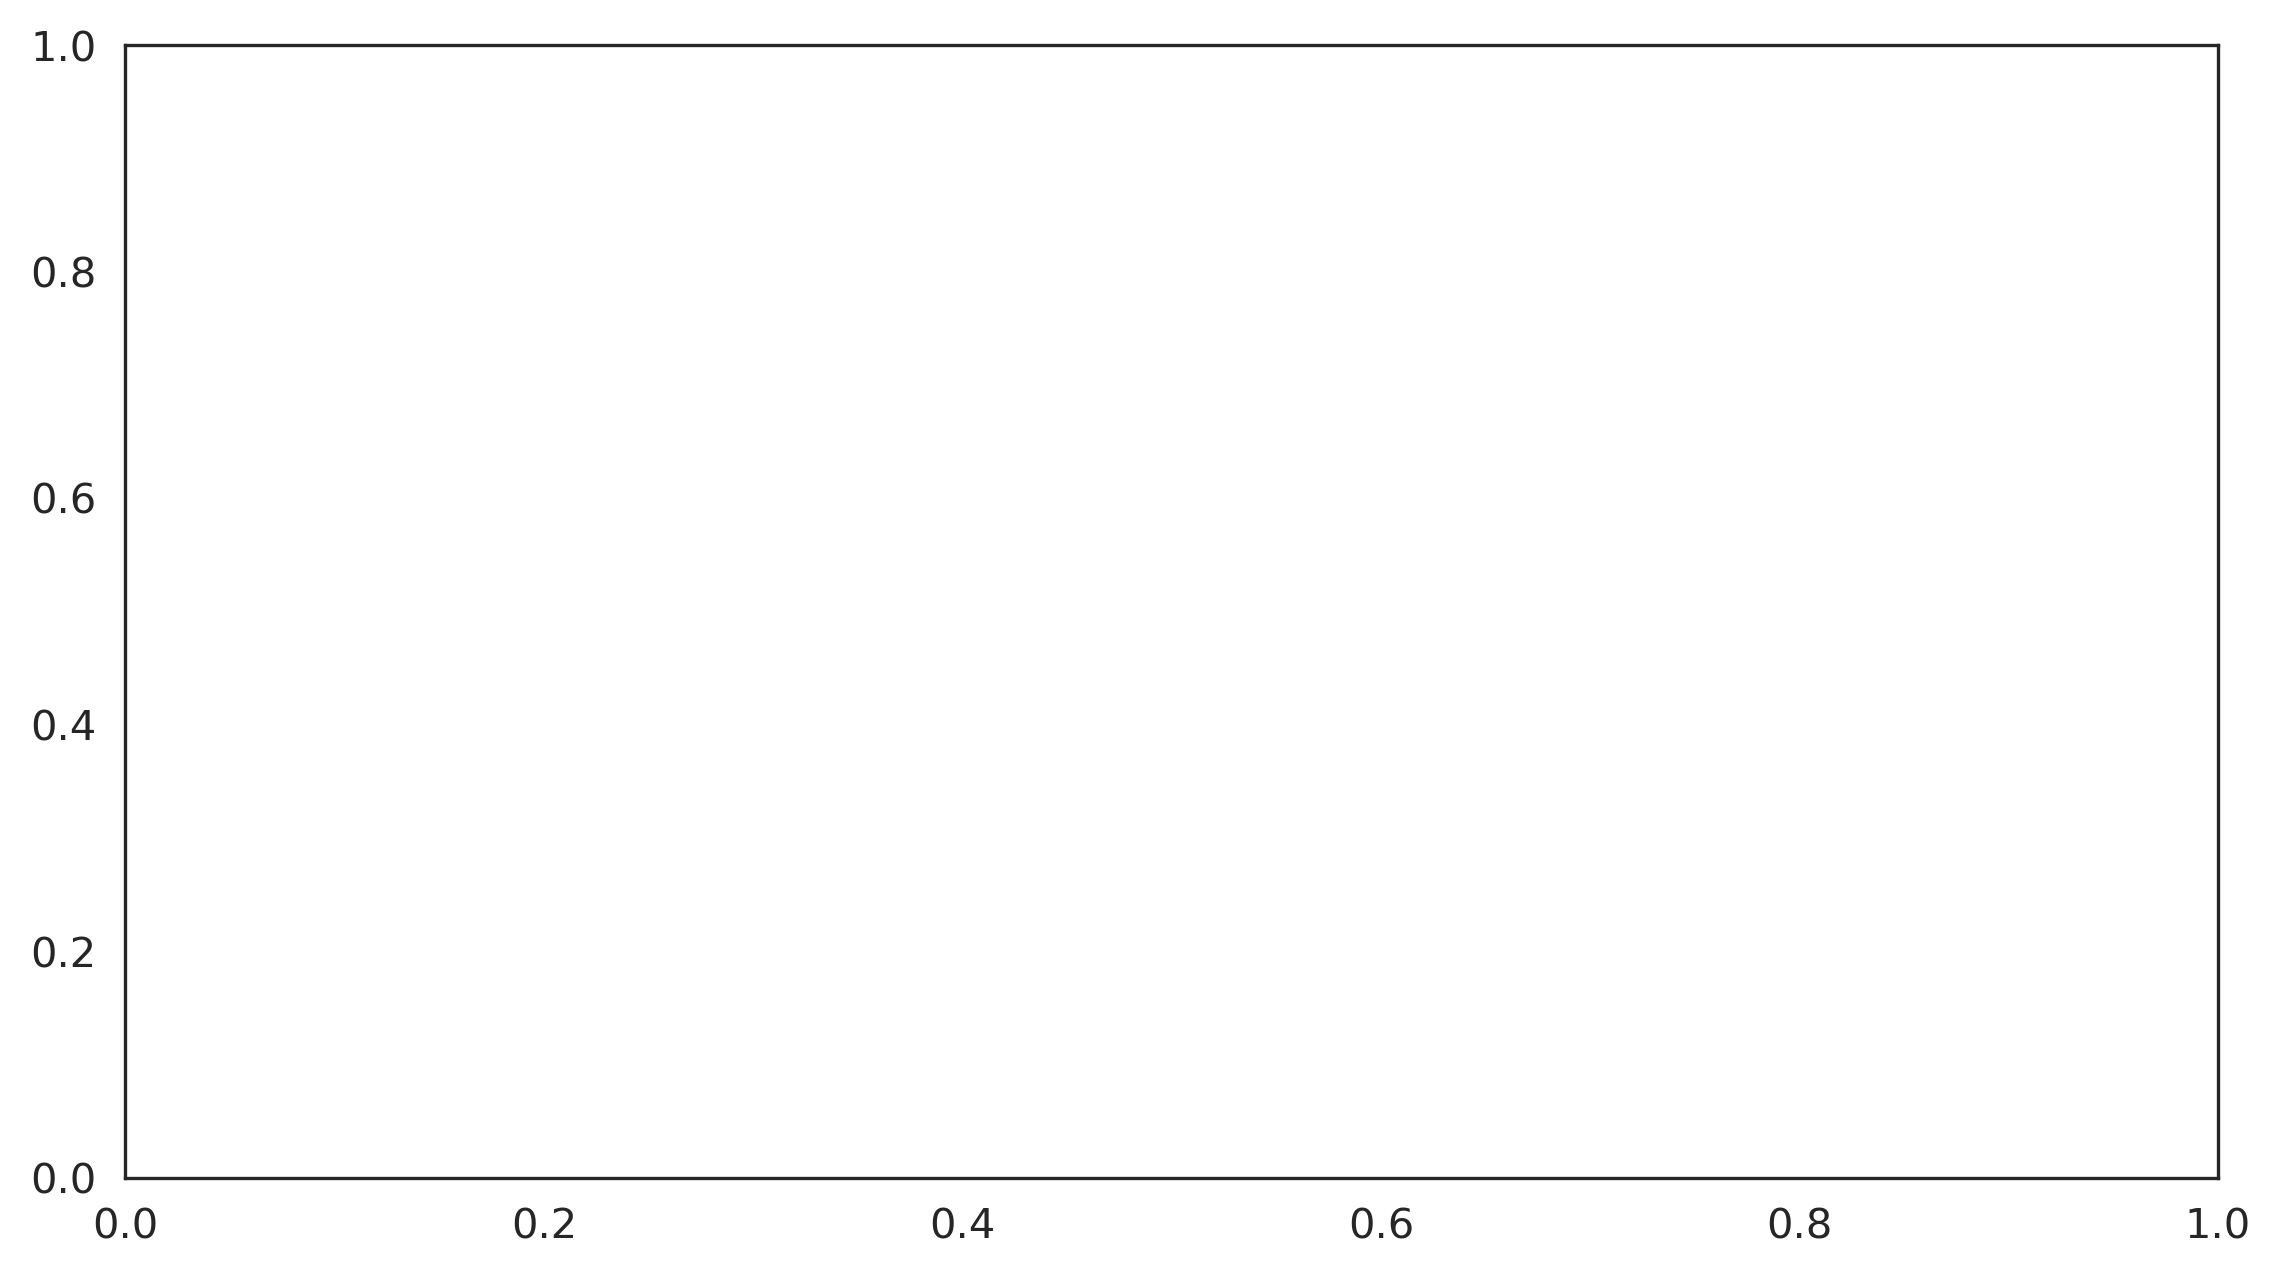

In [10]:
#HISTOGRAMS
#counts_df = pd.read_csv('/project_cephfs/3022017.06/ENIGMA_ANX/Run2/vox/NPM_comparisons/counts_per_diagnosis_affective_only.csv')
 
 # Specify the font path
fpath = Path(mpl.get_data_path(), "/project_cephfs/3022017.06/ENIGMA_ANX/arial.ttf")

sns.set_style("white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 9, 5

# Determine the range and bins based on all columns
global_min = counts_df.min().min()
global_max = counts_df.max().max()
bins = np.linspace(global_min, global_max, 200)

# Iterate through columns and create separate plots
for col in counts_df.columns:
    data_to_plot = counts_df[col].dropna()

    fig, ax = plt.subplots()
    sns.histplot(data=data_to_plot, color="#B7092C", kde=True, stat="percent", alpha=0.2, bins=bins)

    sns.despine(top=True, right=True, left=False, bottom=False)
    plt.xlim(0, 20000)
    plt.xticks(font=fpath)
    plt.ylim(0, max(data_to_plot))
    plt.yticks(font=fpath)
    plt.xlabel(f'Number of deviations ± 2.6 ({col})', font=fpath)
    plt.ylabel('Percentage of sample', font=fpath)
    plt.show()
 